Modified from 
https://lectures.quantecon.org/jl/lake_model.html

# Some utility functions
These will be added to libraries in the future, so no needto understand the details

In [1]:
using Parameters, NamedTuples, MacroTools

#Finds the fixed point of an operator.  This will be replaced by the NLsolve.jl 
function fixedpoint(f, x0; tol = 1E-10, maxiter=100)
    residual = Inf
    iter = 1
    xold = x0
    while residual > tol && iter < maxiter
        xnew = f(xold)        
        residual = norm(xold - xnew);
        xold = xnew
        iter += 1
    end
    return xold
end

#Generator for tuples with keyw
macro with_kw(args...)
    splits = map(args) do arg
        @match arg begin
            (a_ = b_) => (a, b)
            any_ => error("All arguments must be assignments")
        end
    end
    esc(:(
        (;$(map(splits) do pair
            Expr(:kw, pair[1], pair[2])
        end...),) -> 
        $NamedTuples.@NT($(map(splits) do pair
            Expr(:kw, pair[1], pair[1])
        end...))
    ))
end


@with_kw (macro with 1 method)

In [2]:
using QuantEcon
#Returns a generator to create named tuples with default parameters for anything not overwritten
#e.g. lm_defaults() # returns all defaults
#     lm_defaults(b = 0.02) #returns defaults except for b
lm_defaults = @with_kw(λ=0.283, α=0.013,b=0.0124, d=0.00822);

#Calculate transition matrices
function lakemodel_transitions(lm)
    @unpack λ, α, b, d = lm
    g = b - d
    A = [(1-λ) * (1-d) + b  (1-d) * α + b;
         (1-d) * λ          (1-d) * (1-α)]
    A_hat = A ./ (1 + g)
    return A, A_hat
end


lakemodel_transitions (generic function with 1 method)

## Calculations using the A and A_hat
Here, we show an |lternative method to calculate each, for a different style

In [3]:
#To calculate the steady state, iterate or use the markov chain A_hat
rate_steady_state(A_hat) = fixedpoint(x -> A_hat * x, [1.0; 0.0]) #Iterate the fixed point.  No absorbing states, so initial condition does not matter
rate_steady_state_alt(A_hat) = stationary_distributions( MarkovChain(A_hat')) #Alternatively, it is the stationary_distribution of the A_hat' markov chain

#For an arbitrary C.  Can be stochastic or otherwise
function simulate_path(C, x0, T)
    x_path = similar(x0, 2, T) #Preallocations a 2xT matrix of the same type as x0
    x = copy(x0)
    for t in 1:T
        x_path[:, t] = x #puts result into matrix
        x = C * x #Calculates the next result
    end
    return x_path
end

simulate_path_alt(C, x0, T) = [C^j * x0 for j=0:(T-1) ] #Comprehension.  Note, passes back array of arrays

simulate_path_alt (generic function with 1 method)

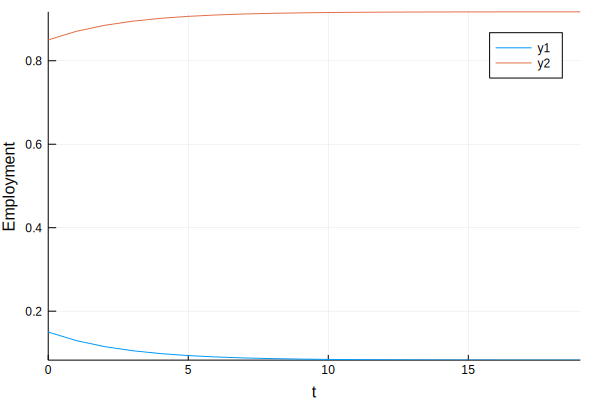

In [4]:
using Plots
lm = lm_defaults()
A, A_hat = lakemodel_transitions(lm)

#Calculate the steady state
@show xbar = rate_steady_state(A_hat)

#Simulate
x0 = [0.15; 0.85]
T= 20
@assert sum(x0) ≈ 1 #otherwise, it is not a proper pdf

rates = simulate_path(A_hat, x0, T)
plot(0:T-1, rates[1,:], xlabel="t", ylabel="Unemployment")
plot!(0:T-1, rates[2,:], xlabel="t", ylabel="Employment")

## Proportion of Time Unemployed

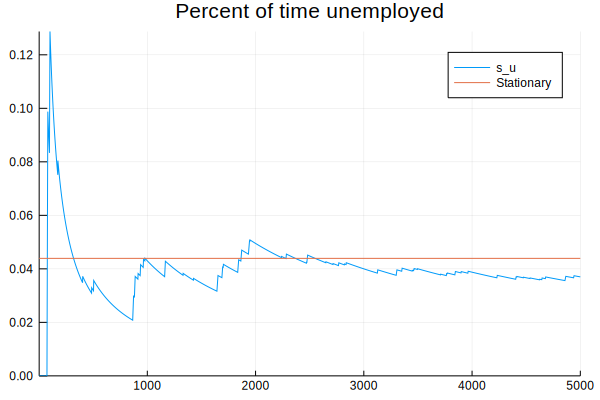

In [5]:
lm = lm_defaults(d=0.0, b=0.0) #No death or birth
T = 5000     # Simulation length

α, λ = lm.α, lm.λ
P = [(1 - λ)     λ; 
     α       (1 - α)]

mc = MarkovChain(P, [1; 2])     # 1=unemployed, 2=employed
xbar = stationary_distributions(mc)[1]

s_path = simulate(mc, T; init=2) #Start employted
s_path_u = cumsum(s_path .== 1 , 1) ./ ( 1:T) #sums the number of times the state is = 1, then divides by the number of time periods
plot(1:T, s_path_u, label="s_u", title="Percent of time unemployed")
plot!(1:T, xbar[1] * ones(1,T)', label="Stationary")

## Code to solve the McCall model
Copied from the McCall lecture

In [35]:
function solve_mccall_model(mcm; tol=1e-8, max_iter=2000, U_iv = 1.0, V_iv = ones(length(mcm.w)))
    @unpack α, β, σ, c, γ, w, p, u = mcm

    #Calculate the utility at the wages and unemployment
    #Don't want to have w[i] = 0 for any i, so set to close to 0
    u_w = u.(max.(w, 1E-6), σ)
    u_c = u(c, σ)
    @show u_w
    
    #Value function iteration
    # Setting up map T(x) -> x.  The fixed point is a x* such that T(x*) = x*
    function T(x) #Bellman operator
        V = x[1:end-1]
        U = x[end]
        return [u_w + β * ((1 - α) * V + α * U);
                u_c + β * (1 - γ) * U + β * γ * dot(max.(U, V), p)]        
    end
    
    x_iv = [V_iv; U_iv]; #Initial value to use for the fixed point
    xstar = fixedpoint(T, x_iv; tol = tol, maxiter=max_iter)    
    V = xstar[1:end-1]
    U = xstar[end]
    #Find the policy, where V > U  
    #Check: are the signs on infinity correct?
    wbarindex = searchsortedfirst(V - U, 0.0)
    if(wbarindex > length(w))
        wbar = -Inf
    elseif(wbarindex > 0)
        wbar = w[wbarindex]
    else
        wbar = Inf
    end
    return V, U, wbar
end



solve_mccall_model (generic function with 1 method)

## Default Parameters for the McCall Model

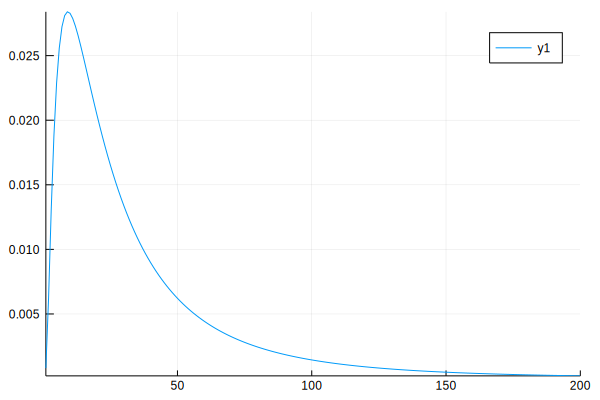

In [36]:
#Wage values and distribution to use for probabilities.
using Distributions

# The default wage distribution: a discretized log normal
log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
w_vec = linspace(1e-3, max_wage, wage_grid_size + 1)
logw_dist = Normal(log(log_wage_mean), 1)
cdf_logw = cdf.(logw_dist, log.(w_vec))
pdf_logw = cdf_logw[2:end] - cdf_logw[1:end-1]
p_vec = pdf_logw ./ sum(pdf_logw)
w_vec = (w_vec[1:end-1] + w_vec[2:end]) / 2


#Generator for the named tuple to hold all parameters
mcm_defaults = @with_kw(
    u = (c,σ) -> (c.^(1 - σ) - 1) / (1 - σ),
    α = 0.013,
    β = 0.98,
    γ = 1.0,
    σ = 2.0,
    w = w_vec,
    p = p_vec,
    c = 0) #Generally overwritten)

using Plots
plot(1:length(p_vec),p_vec)

## Solving the problem given a fiscal policy
This shows an example of how you might call the function

In [37]:
τ_test = 0.50760695037823
c_test = 5.0
mcm = mcm_defaults(c = c_test - τ_test, w = collect(w_vec - τ_test))
V, U, w_bar = solve_mccall_model(mcm)

u_w = [-999999.0, -0.30143, 0.382098, 0.594875, 0.698647, 0.760098, 0.800732, 0.829595, 0.851154, 0.867871, 0.881212, 0.892106, 0.901169, 0.908828, 0.915386, 0.921063, 0.926026, 0.930402, 0.93429, 0.937766, 0.940892, 0.94372, 0.946289, 0.948634, 0.950783, 0.952759, 0.954583, 0.956271, 0.957838, 0.959297, 0.960658, 0.961931, 0.963124, 0.964245, 0.9653, 0.966294, 0.967233, 0.968121, 0.968962, 0.969759, 0.970517, 0.971238, 0.971924, 0.972579, 0.973203, 0.9738, 0.974371, 0.974917, 0.975441, 0.975943, 0.976425, 0.976888, 0.977334, 0.977762, 0.978175, 0.978572, 0.978955, 0.979325, 0.979682, 0.980027, 0.980361, 0.980683, 0.980995, 0.981297, 0.98159, 0.981874, 0.982149, 0.982415, 0.982674, 0.982926, 0.98317, 0.983407, 0.983638, 0.983863, 0.984081, 0.984294, 0.9845, 0.984702, 0.984898, 0.98509, 0.985276, 0.985458, 0.985636, 0.985809, 0.985978, 0.986143, 0.986305, 0.986462, 0.986616, 0.986767, 0.986914, 0.987058, 0.987199, 0.987337, 0.987471, 0.987603, 0.987733, 0.987859, 0.987983, 0.988105, 0.9

([-3.05436e7, 9.50182, 30.3793, 36.8783, 40.0479, 41.9248, 43.1659, 44.0475, 44.706, 45.2166  …  49.0631, 49.064, 49.065, 49.066, 49.067, 49.0679, 49.0689, 49.0698, 49.0707, 49.0716], 48.0784612559719, 26.26823554962177)

## Settings for Lake Model with Endogenous Acceptance

In [22]:
function compute_steady_state_quantities(c, τ)
    mcm = mcm_defaults(c = c - τ, w = collect(w_vec - τ))
    V, U, w_bar = solve_mccall_model(mcm)

    λ = mcm.γ * sum(p_vec[w_vec - τ .> w_bar])

#     Compute steady state employment and unemployment rates
    lm = lm_defaults(d=0.0, b=0.0, λ=λ) 
    A, A_hat = lakemodel_transitions(lm)
    x = rate_steady_state(A_hat)
    u_rate, e_rate = x

     # Compute steady state welfare
     w = sum(V .* p_vec .* (w_vec - τ .> w_bar)) / sum(p_vec .* (w_vec - τ .> w_bar))
     welfare = e_rate .* w + u_rate .* U

    return u_rate, e_rate, welfare, λ
end

compute_steady_state_quantities (generic function with 1 method)

In [23]:
function find_balanced_budget_tax(c)
    function steady_state_budget(t::Real)
      u_rate, e_rate, w, λ = compute_steady_state_quantities(c, t)
      return t - u_rate * c
    end

    τ = brent(steady_state_budget, 0.0, 0.9 * c)

    return τ, λ
end
find_balanced_budget_tax(10)


(0.5016210310238849, 0.283)

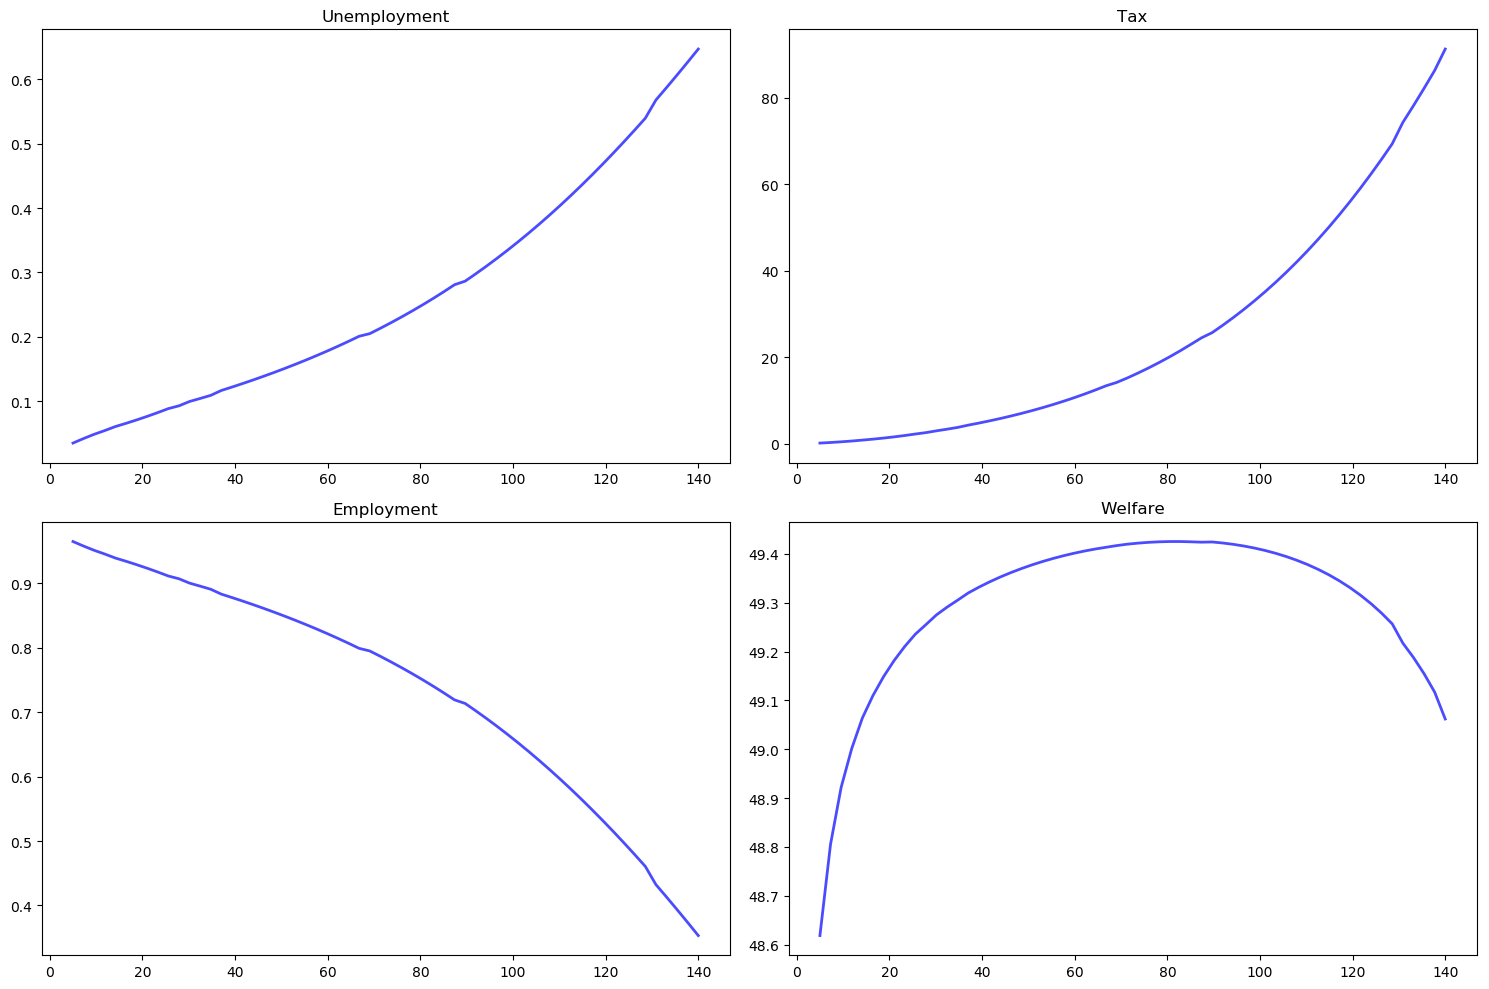

tax_vec = [0.175592, 0.307354, 0.466963, 0.646958, 0.859887, 1.08093, 1.3301, 1.60957, 1.92159, 2.26855, 2.59138, 3.00733, 3.38747, 3.79458, 4.32496, 4.79906, 5.30455, 5.84288, 6.41558, 7.02425, 7.6706, 8.35645, 9.08372, 9.85447, 10.6709, 11.5353, 12.4502, 13.4182, 14.1894, 15.2201, 16.3433, 17.5305, 18.7849, 20.1099, 21.5092, 22.9863, 24.493, 25.6838, 27.3848, 29.1772, 31.0648, 33.0513, 35.1403, 37.3354, 39.64, 42.0574, 44.5909, 47.2432, 50.0173, 52.9156, 55.9405, 59.0941, 62.3782, 65.7944, 69.3442, 74.272, 78.1376, 82.139, 86.2765, 91.2377]


In [24]:
# Levels of unemployment insurance we wish to study
Nc = 60
c_vec = linspace(5.0, 140.0, Nc)

tax_vec = Vector{Float64}(Nc)
unempl_vec = Vector{Float64}(Nc)
empl_vec = Vector{Float64}(Nc)
welfare_vec = Vector{Float64}(Nc)

for i = 1:Nc
    t, λ = find_balanced_budget_tax(c_vec[i])
    u_rate, e_rate, welfare = compute_steady_state_quantities(c_vec[i], t)
    tax_vec[i] = t
    unempl_vec[i] = u_rate
    empl_vec[i] = e_rate
    welfare_vec[i] = welfare
end
@show tax_vec
using PyPlot
 fig, axes = subplots(2, 2, figsize=(15, 10))

 plots = [unempl_vec, empl_vec, tax_vec, welfare_vec]
 titles = ["Unemployment", "Employment", "Tax", "Welfare"]

 for (ax, plot, title) in zip(axes, plots, titles)
     ax[:plot](c_vec, plot, "b-", lw=2, alpha=0.7)
     ax[:set](title=title)
 end

 fig[:tight_layout]()

```none
Initial Steady State: [0.0826681, 0.917332]
```
